    © Copyright (C) 2023
    Collaborateurs : Amine YOUCEF KHODJA, Koceila KEMICHE, Hoang Son NGUYEN.*

In [9]:
import numpy as np
import cv2 as cv
from fourmis import *
from sys import argv
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
from bibFunctions import *
# from bibFunctions import KalmanFilter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Creation des datasets

## Lecture de la video

In [10]:
def blur(image):
    # creation du noyau symetrique
    noy_len = 8
    noyau = np.ones((noy_len,noy_len))/(noy_len**2)
    ddepth = -1
    return cv.filter2D(image,ddepth,noyau)


def dyna_tracking(path_to_video,positions_nourriture,position_nid,priori_fourmis,see=False):
    # Pour le stockage des positions 
    dico_positions = {}
    dico_nid = {}
    list_dico_nouriture = []
    # pour gerer les ids des fourmis
    gFourmis = GestionFourmis()
    cpt = 0
    # lecture de la video et recuperation des frames
    video = cv.VideoCapture(path_to_video)
    ret, frame = video.read()
#     frames_tot = int(video.get(cv.CAP_PROP_FRAME_COUNT))
    height, width, layers = frame.shape
    fgbg = cv.createBackgroundSubtractorMOG2()

    # valeur du seuil
    thresh_val = 50
    # compteur
#     count_frame = 0

    while True:
        ret , frame = video.read()
        if not ret:
            break
        # pour enlever les bords inutiles
        frame = frame[:,370:1430]
        colors = get_random_colors(len(positions_nourriture)) 

        #focus sur le nid
        (ni_x,ni_y),(ni_w,ni_h) = position_nid
        cv.putText(frame,"Nid",(ni_x,ni_y-10),cv.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255))
        cv.rectangle(frame,(ni_x,ni_y),(ni_x+ni_w,ni_y+ni_h),(142, 24, 42),2)


        # focus sur les differentes zones de la nouriture
        for i_pos in range(len(positions_nourriture)):
            list_dico_nouriture.append({})
            (nou_x,nou_y),(nou_w,nou_h) = positions_nourriture[i_pos]
            cv.putText(frame,f"Nouriture {i_pos}",(nou_x,nou_y-10),cv.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255))
            cv.rectangle(frame,(nou_x,nou_y),(nou_x+nou_w,nou_y+nou_h),(190, 100, 104),2)

        # appliquer le filtre et seuillage
        gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        fgmask = fgbg.apply(frame)
        masque = blur(fgmask)
        _, masque = cv.threshold(masque, thresh_val, 255, cv.THRESH_BINARY)

        # dessiner les contours
        cons, _ = cv.findContours(masque, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
        img = (1 - masque)*gray
        for c in cons: # tracer box
            id = None
            (x,y,w,h) = cv.boundingRect(c) # coord
            centre = np.array([x + w/2,y + h/2])
            if gFourmis.getNbFourmis() == 0:
                fourmis = Fourmis(cpt, x,y,w,h)
                gFourmis.add(fourmis)
                id = fourmis.getId()
                cpt +=1
            else:
                f_tmp = Fourmis(cpt, x,y,w,h)
                centre = np.array([x + w/2,y + h/2])
                d = gFourmis.getListe()
                id_chercher = trouvePlusProche(f_tmp, d)
                if id_chercher == -1:
                    gFourmis.add(f_tmp)
                    id = f_tmp.getId()
                    cpt +=1
                else:
                    gFourmis.majFourmis(id_chercher, (centre,None))
                    id =id_chercher

            for i_pos in range(len(positions_nourriture)):
                dico_nouri = list_dico_nouriture[i_pos]
                (nou_x,nou_y),(nou_w,nou_h) = positions_nourriture[i_pos] 
                if x >= nou_x and x <= nou_x+nou_w and y >= nou_y and y <= nou_y+nou_h :
                    if id in dico_nouri.keys():
                        (id,coun) = dico_nouri[id]
                        coun += 1
                        dico_nouri[id] = (id,coun)
                    else:
                        dico_nouri[id] = (id,1)

            if id in dico_nid.keys():
                id,coun = dico_nid[id]
                coun += 1
                dico_nid[id] = (id,coun)
            else:
                dico_nid[id] = (id,1)


            if id in dico_positions.keys():
                dico_positions[id].append([id,x,y,w,h])
            else:
                dico_positions[id] = [[id,x,y,w,h]]

            cv.putText(frame,f"{id}",(x,y),cv.FONT_HERSHEY_SIMPLEX,1,(0,0,255))
            cv.rectangle(frame,(x,y),(x+w,y+h),(143,255,46),3)

        if see:
            cv.imshow('video', frame)
            if cv.waitKey(1) & 0xFF == ord('q'):
                break
#         else:
#             if nb_frame > frames_tot:
#                 break

            #recuperer à priori fourmis
        if priori_fourmis != None and list(dico_positions.keys())[-1] == priori_fourmis:
            break

    video.release()
    cv.destroyAllWindows()
    
    
    return dico_positions,list_dico_nouriture,dico_nid

def get_plots_(dico,identifi,direction=False):

    # recuperer les positions
    values = list(dico.values())
   
    # recuperer les coordonnées une par une
    x = np.array(values[identifi])[:,1]
    y = np.array(values[identifi])[:,2]
    w = np.array(values[identifi])[:,3] 
    h = np.array(values[identifi])[:,4] 

    # normalisation sur l'echelle  : pour afficher les directions
    if direction:
        w = np.array(values[identifi])[:,3] / 15
        h = np.array(values[identifi])[:,4] / 15
    
    print(f"Nombre de deplacements capturés pour la fourmi {identifi} : {len(x)}")
    
    plt.figure(figsize=(15,5))
    plt.title(f"Deplacements de la fourmi {identifi} sur l'axe X")
    plt.plot(x,'red')
    plt.show()

    plt.figure(figsize=(15,5))
    plt.title(f"Deplacements de la fourmi {identifi} sur l'axe Y")

    plt.plot(y,'green')
    plt.show()


    plt.figure(figsize=(15,8))
    plt.title(f"Simulation des deplacements de la fourmi {identifi}")
    plt.scatter(x,y)
    if direction:
        for i in range(len(w)):
            plt.arrow(x[i],y[i],w[i],h[i],color='pink',width=0.2)
    plt.show()


def create_dataframe(dico,COLUMN_NAMES):
    nb_fourmis = len(list(dico.keys()))
    dataF = pd.DataFrame(columns=COLUMN_NAMES)
    for i in range(nb_fourmis):
        positions = np.array(dico.get(i))
        dataF_tmp = pd.DataFrame(positions,columns=COLUMN_NAMES)
        dataF = pd.concat([dataF,dataF_tmp],ignore_index=True)

    return dataF

def get_random_colors(n):
    colors = []
    r = np.random.randint(0,255,n) / 255
    g = np.random.randint(0,255,n) / 255        
    b = np.random.randint(0,255,n) / 255
    
    return list(zip(r,g,b))


def get_positions(dataset,nb_fourmis):
    positions = []
    X_s  = []
    Y_s  = []
    for i in range(nb_fourmis):
        X = list(dataset[dataset.iloc[:,0] == i].iloc[:,1])
        Y = list(dataset[dataset.iloc[:,0] == i].iloc[:,2])
        positions.append(list(zip(X,Y)))
        X_s.extend(X)
        Y_s.extend(Y)

    return np.array(positions) , np.array(X_s) , np.array(Y_s)

In [11]:
# une video de 2mn
path_to_video = 'VIDEOS/cutted_vert.mp4'
positions_nourriture = [((450,450),(170,170)) , ((420,60),(150,120)) ]
position_nid = ((710,800),(50,50))
priori_fourmis = 200
dico_positions,list_dico_nouriture,dico_nid = dyna_tracking(path_to_video,positions_nourriture,position_nid,priori_fourmis,see=False)

In [12]:
print(list_dico_nouriture[0])
print(list_dico_nouriture[1])
print(dico_nid)
# print(dico_positions)

{8: (8, 86), 7: (7, 319), 90: (90, 765), 123: (123, 10), 0: (0, 1), 163: (163, 16)}
{82: (82, 110), 147: (147, 84)}
{0: (0, 2), 1: (1, 346), 2: (2, 3051), 3: (3, 1014), 4: (4, 1235), 5: (5, 1054), 6: (6, 1544), 7: (7, 1639), 8: (8, 1007), 9: (9, 42), 10: (10, 966), 11: (11, 1381), 12: (12, 101), 13: (13, 592), 14: (14, 879), 15: (15, 1725), 16: (16, 1331), 17: (17, 1688), 18: (18, 826), 19: (19, 1055), 20: (20, 1852), 21: (21, 1051), 22: (22, 989), 23: (23, 2270), 24: (24, 1164), 25: (25, 2456), 26: (26, 730), 27: (27, 670), 28: (28, 1349), 29: (29, 1919), 30: (30, 1704), 31: (31, 1993), 32: (32, 966), 33: (33, 1016), 34: (34, 1602), 35: (35, 808), 36: (36, 1822), 37: (37, 875), 38: (38, 2004), 39: (39, 2080), 40: (40, 370), 41: (41, 1181), 42: (42, 344), 43: (43, 1385), 44: (44, 1240), 45: (45, 2025), 46: (46, 2957), 47: (47, 1151), 48: (48, 636), 49: (49, 859), 50: (50, 135), 51: (51, 1564), 52: (52, 1986), 53: (53, 1425), 54: (54, 2427), 55: (55, 943), 56: (56, 1290), 57: (57, 357),

(array([[2., 0., 0., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 1.],
        ...,
        [2., 0., 0., ..., 0., 0., 0.],
        [2., 0., 0., ..., 0., 0., 0.],
        [2., 0., 0., ..., 0., 0., 0.]]),
 array([   0. ,  305.1,  610.2,  915.3, 1220.4, 1525.5, 1830.6, 2135.7,
        2440.8, 2745.9, 3051. ]),
 <a list of 175 BarContainer objects>)

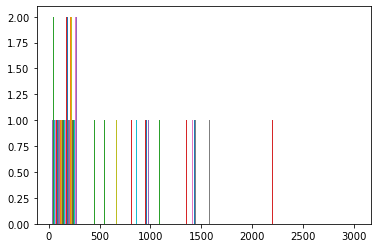

In [13]:
plt.hist(list(dico_nid.values()))

## Affichage de quelques plots

Nombre de deplacements capturés pour la fourmi 8 : 1007


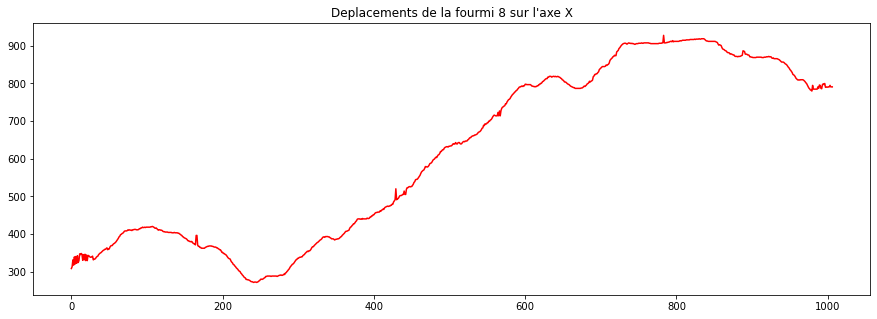

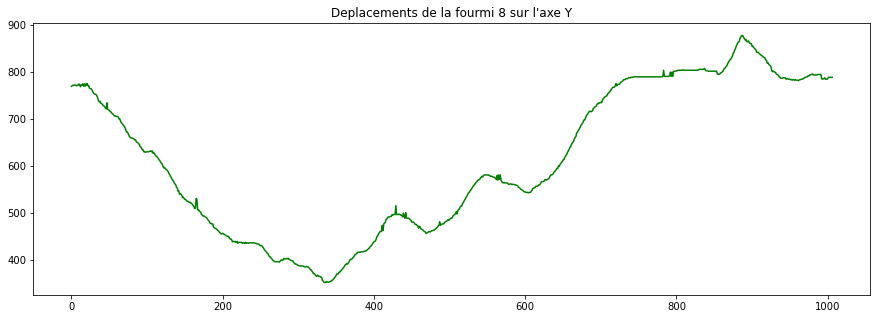

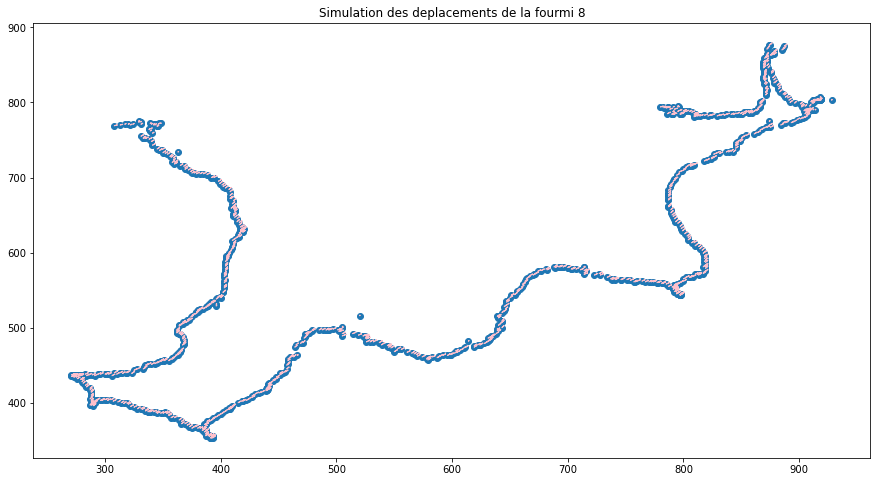

In [14]:
get_plots_(dico_positions,8,direction=True)

In [15]:
COLUMN_NAMES = ['Id_ant','X','Y','Width','Height']
dataset_positions = create_dataframe(dico_positions,COLUMN_NAMES)
dataset_positions

,Id_ant,X,Y,Width,Height
0,0,0,0,1060,1080
1,0,526,552,1,1
2,1,68,1045,14,12
3,1,77,1052,2,1
4,1,72,1049,9,11
...,...,...,...,...,...
159897,173,12,654,32,29
159898,173,12,654,33,29
159899,173,12,654,33,29
159900,173,13,654,32,29


In [16]:
COLUMN_NAMES = ['id_ant','nb_visite_nid']
# dataset_nid = create_dataframe(dico_nid,COLUMN_NAMES)
dataset_nid = pd.DataFrame(dico_nid.values(),columns=COLUMN_NAMES)
dataset_nid

,id_ant,nb_visite_nid
0,0,2
1,1,346
2,2,3051
3,3,1014
4,4,1235
...,...,...
170,170,69
171,171,44
172,172,79
173,173,78


In [17]:
COLUMN_NAMES = ['id_ant','nb_visite_nouri0']
# dataset_nid = create_dataframe(dico_nid,COLUMN_NAMES)
dataset_nouri0 = pd.DataFrame(list_dico_nouriture[0].values(),columns=COLUMN_NAMES)
dataset_nouri1 = pd.DataFrame(list_dico_nouriture[1].values(),columns=COLUMN_NAMES)
dataset_nouri0

,id_ant,nb_visite_nouri0
0,8,86
1,7,319
2,90,765
3,123,10
4,0,1
5,163,16


In [18]:
dataset_nouri1

,id_ant,nb_visite_nouri0
0,82,110
1,147,84


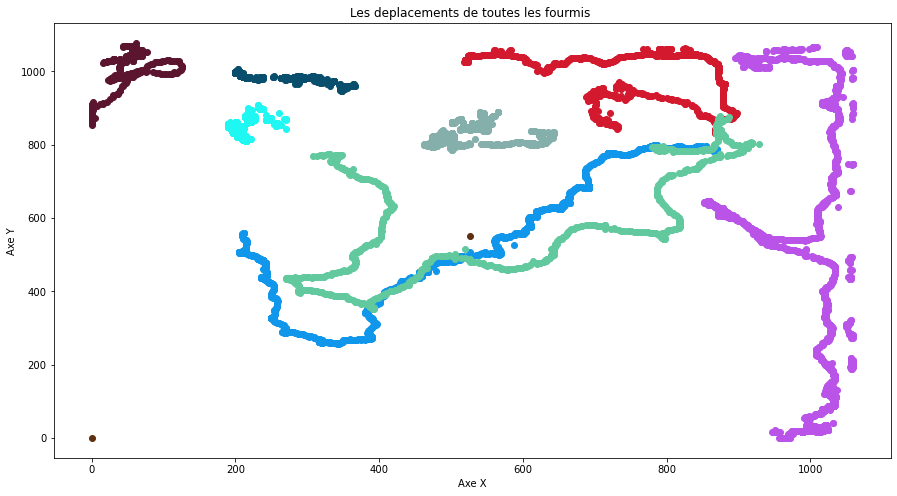

In [19]:
nb_fourmis = np.unique(dataset_positions.iloc[:10000,0]).shape[0]
plt.figure(figsize=(15,8))
# colors = plt.cm.get_cmap('viridis', nb_fourmis)
colors = get_random_colors(nb_fourmis)
plt.title("Les deplacements de toutes les fourmis ")
for i in range(nb_fourmis):  
    X = list(dataset_positions[dataset_positions.iloc[:,0] == i].iloc[:,1])
    Y = list(dataset_positions[dataset_positions.iloc[:,0] == i].iloc[:,2]) 
    plt.scatter(X,Y,c=colors[i],label=str(i))
# plt.legend(loc="upper left")
plt.xlabel("Axe X")
plt.ylabel("Axe Y")
plt.show()

## Auto completion des positions

Nombre de deplacements capturés pour la fourmi 125 : 562


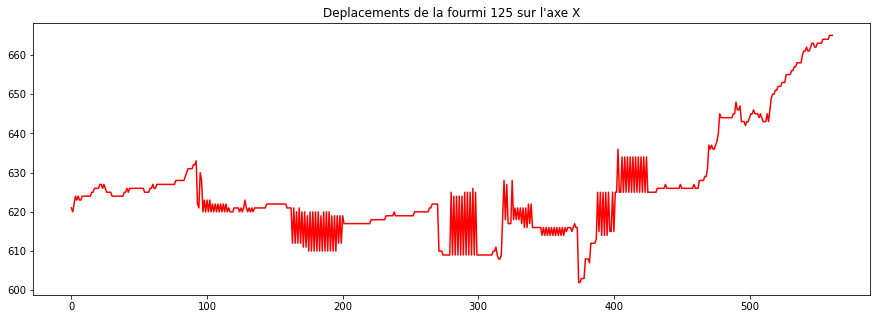

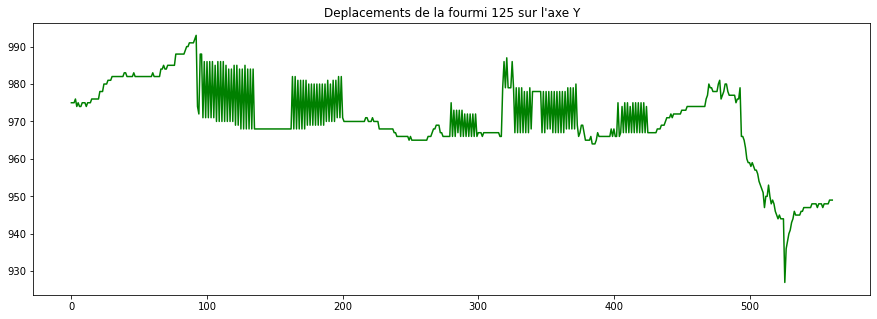

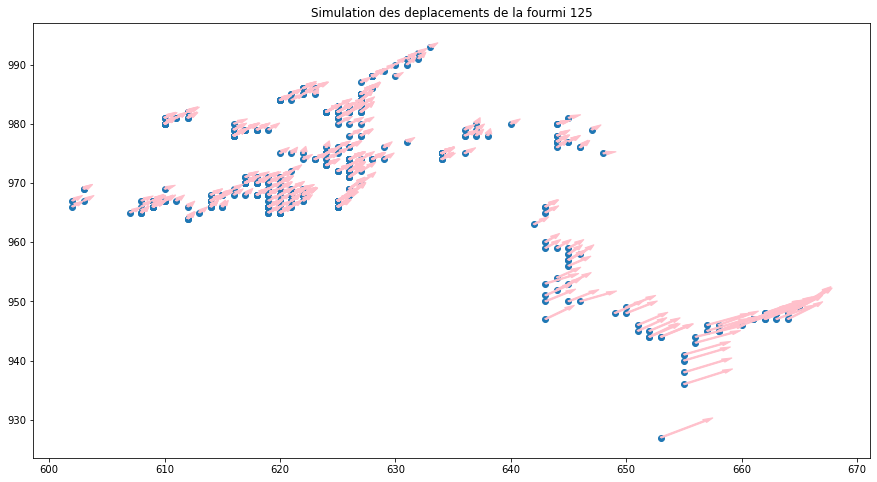

In [20]:
get_plots_(dico_positions,125,direction=True)

In [64]:
def if_disappear(pos,seuil):
    vect_difference  = pos[:-1] - pos[1:]        
    # renvoie les indices 
    return np.where(vect_difference > seuil)[0]

In [88]:
pos = np.array(dico_positions[125])[:,0:2]
indices = if_disappear(pos,15)
ind = indices[0]

In [91]:
pos = np.array(dico_positions[125])[:,0:2]
kf = KalmanFilter()
positions_train = pos[:ind-1,0:2]
reprise_pos = tuple(pos[ind][0:2])
print("La position de reprise  : ",reprise_pos)
print("Les positions pour l'entrainement (shape):",positions_train.shape)

pred_positions , burnin , nb_positions = go_to_convergence(kf,pos,reprise_pos,verbose=True)
print("Les positions predites  : ",pred_positions)

La position de reprise  :  (125, 625)
Les positions pour l'entrainement (shape): (279, 2)
Convergé au bout de  1  positions
Les positions predites  :  [(125, 665)]


## Preparation de l'environnement

In [27]:
nb_fourmis = np.unique(dataset_positions.iloc[:,0]).shape[0]
positions , X , Y = get_positions(dataset_positions,nb_fourmis)
bins_h,bins_w = (8,8)
max_X = max(X)
max_Y = max(Y)
grid_h,grid_w = (max_X,max_Y)
# recuperer un grille 
formes_grille = discretisation_uniforme_grille(grid_h,grid_w,bins_h,bins_w)

/tmp/ipykernel_6473/3008894931.py:194: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(positions) , np.array(X_s) , np.array(Y_s)


In [42]:
bag_of_positions_ = get_bag_of_positions(positions , formes_grille , bins_h,bins_w)
bag_of_positions_train = bag_of_positions_ [:100,]
bag_of_positions_test = bag_of_positions_ [100:,]

## Logistique Regression

In [43]:
nb_fourmis_cl0 = int(nb_fourmis // 2)
classes = np.array([1 for i in range(nb_fourmis_cl0)] + [-1 for i in range(nb_fourmis - nb_fourmis_cl0)])

print(classes.shape)
print(bag_of_positions_train.shape)
print(bag_of_positions_test.shape)
classes_0 = classes[:100,]
classes_1 = classes[100:,]

lr_clf = LogisticRegression(random_state=0, solver='lbfgs',max_iter=100,n_jobs=-1)
lr_clf.fit(bag_of_positions_train, classes_0)

pred_lr_train = lr_clf.predict(bag_of_positions_train)
print("Train accuracy : ",accuracy_score(classes_0, pred_lr_train))


pred_lr_test = lr_clf.predict(bag_of_positions_test)
print("Test accuracy : ",accuracy_score(classes_1, pred_lr_test))

(175,)
(100, 64)
(75, 64)
Train accuracy :  0.94
Test accuracy :  0.25333333333333335


/home/amine/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
# from ultralytics import YOLO
# import PIL
# import torch

# from torchvision import transforms
# model = YOLO('best.pt') # create new model object
# # model.load_state_dict(torch.load(path_to_state_dict))
# # model.eval()

# # load single image or dataset
# img = PIL.Image.open("screen_vert.png")

# convert_tensor = transforms.ToTensor()

# x = convert_tensor(img) # transform to tensor

# with torch.inference_mode():
#     output = model(x)